# Optics of the *M. amalphitanum* eye
- View ommatidia measurements from AM and team 
- Calculate optical parameters from physical measurements
- Perform clustering on these physical features, compare with lamina circuit clustering

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import math
import os.path
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from cx_analysis.utils import index_by_om, yymmdd_today
from cx_analysis.dataframe_tools import assemble_cxvectors
from cx_analysis.vis.fig_tools import linear_cmap, subtype_cm
from cx_analysis.vis.hex_lattice import hexplot_TEST, hexplot, om_to_hex

In [17]:
plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs=False
fig_path = f'/mnt/home/nchua/Dropbox/lamina_figures/{yymmdd_today()}/{yymmdd_today()}_'
##################
# if save_figs:
#     fig.savefig(fig_path + fname + '.svg')
#     fig.savefig(fig_path + fname + '.png')

In [18]:
tp = '210809'
data_path = f'~/Data/{tp}_lamina/'  

In [19]:
optics_df = pd.read_excel(data_path + 'optics/1911_anastasia_om_measurements.xlsx', index_col=0)
optics_df = optics_df.iloc[1:-2] # remove last two lines of excel file

# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle(data_path + 'optics/201123_rh_len_df.pickle')
for i, v in rh_len.iterrows():
    optics_df.loc[i, 'rhabdom_len'] = float(v)

### Replace manual curvature measurements with JP's ###
optics_df = optics_df.drop(['outer curvature', 'inner curvature'], axis=1)
with open(os.path.expanduser(data_path + 'optics/210723_jp_optics_measurements.json')) as fh:
    jp_data = json.load(fh)

right_om_labels = {'A0': 73, 'B0': 72, 
                  'A1': 71, 'B1': 70, 'C1': 69, 
                  'A2': 68, 'B2': 67, 'C2': 66, 'D2': 65, 
                  'A3': 64, 'B3': 63, 'C3': 61, 'D3': 62, 
                  'A4': 60, 'B4': 57, 'E4': 59,  
                  'A5': 56, 'B5': 55, 'C5': 54, 'D5': 53,
                  'B6': 52, 'E6': 51}

r_in = []
r_out = []
lens_centers_in = {}
lens_centers_out = {}
for om in optics_df.index:
    if om in right_om_labels.keys():
        r_in.append(jp_data['radii_in'][str(right_om_labels[om])])
        r_out.append(jp_data['radii_out'][str(right_om_labels[om])])
        lens_centers_in[om] = np.array(jp_data['centers_in'][str(right_om_labels[om])])
        lens_centers_out[om] = np.array(jp_data['centers_out'][str(right_om_labels[om])])
                                    
    else:
        r_in.append(np.nan)
        r_out.append(np.nan)
# Convert radii and center coordinates to microns
optics_df.loc[:, 'radius_in'] = np.array(r_in) / 1000.0
optics_df.loc[:, 'radius_out'] = np.array(r_out) / 1000.0 
lens_centers_in = pd.Series(lens_centers_in, dtype='object', name='lens_centers_in') / 1000.0
lens_centers_out = pd.Series(lens_centers_out, dtype='object', name='lens_centers_out') / 1000.0

display(optics_df.describe().round(2))

,lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,22.00,22.00
mean,3.01,4.07,6.04,2.49,1.89,26.79,14.26,2.89,3.83
std,0.59,0.93,0.97,0.41,0.45,9.32,1.56,0.89,0.95
min,1.89,2.37,4.14,1.78,1.17,7.81,11.09,1.06,1.88
25%,2.65,3.34,5.52,2.14,1.45,18.09,13.31,2.47,3.04
50%,3.02,4.34,6.45,2.52,2.04,26.41,13.98,3.05,4.24
75%,3.48,4.73,6.73,2.85,2.27,33.77,14.88,3.35,4.53
max,4.19,6.10,7.20,3.10,2.45,42.78,18.25,5.00,4.88


## Lens calculations
### Measurements (all $\mu{m}$)
- Lens: Outer radius of curvature, $r_1$
- Lens: Inner radius of curvature, $r_2$
- Lens: thickness, $t$
- Lens: diameter, $D$
- Rhabdom: distal diameter, $D_{Rh}$
- Rhabdom: length, $l_{Rh}$
- Measurements also taken for the length and distal width of the crystalline cone, and the proximal diameter of the rhabdom (not used for the following calculations) 

### Calculations
- We used the refractive indices of the honey bee lens ($n_l$) and crystalline cone ($n_c$), from Valera & Wiitanen (1970)
- Optical power ($\mu{m}^{-1}$) of the diopteric apparatus (lens + crystalline cone), $P$, calculated using the thick lens formula (Fundamentals of Optics, Jenkins & White, p.84, 2001): 
$$P = P_1 + P_2 - \frac{t}{n_l} P_1 P_2$$
    - $P_1 = \frac{n_l - 1.0}{r_1}$, power from outer lens surface
    - $P_2 = \frac{n_c - n_l}{r_2}$, power from inner lens surface  
- Focal length of the object ($\mu{m}$): $f = 1/P$
- Focal length of the image ($\mu{m}$): $f' = {n_c}/P$
- F-number: $F = f/D$
- The acceptance angle of an ommatidium, $\Delta\rho$, is proscribed by diffraction effects at the lens,  $\Delta\rho_l$, and the geometry of the distal rhabdom tip and the lens, $\Delta\rho_{Rh}$ (Snyder, 1979):
$$\Delta\rho = \sqrt{{\Delta\rho_l}^2 + {\Delta\rho_{Rh}}^2}$$
    - $\Delta\rho_l = \lambda/D$, where we set $\lambda$ = 0.5 $\mu{m}$ (green monochromatic light)
    - $\Delta\rho_{Rh} = D_{Rh}/f$
- Optical sensitivity to an extended broadband-spectrum source, $S$ ($\mu{m}^2{sr}$), approximated by:  
$$S = (\frac{\pi}{4})^2 D^2 {\Delta\rho}^2 \frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$$
    - See [Fredriksen and Warrant, 2008](https://dx.doi.org/10.1098%2Frsbl.2008.0467); [Kirschfeld, 1974](https://doi.org/10.1515/znc-1974-9-1023)
    - k is the peak absorbtion (length) coefficient of the visual pigment, taken as 0.0067 $\mu{m}^-1$ (Warrant et al., 2004)
    - Notes: facet area is $\frac{\pi{D}^2}{4}$, the fraction of incident light absorbed is $\frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$



In [20]:
def focal_length(r_outer: float, r_inner: float, thin_approx: bool=False, t: float=0.0) -> float:

    nl = 1.452 # lens
    nc = 1.348 # cone
    # lens power IN MICROMETERS
    p1 = (nl - 1.0)/r_outer # interface air->lens 
    p2 = (nc - nl)/r_inner # interface lens->cone
    
    if thin_approx:
        return 1.0/(p1 + p2)
    else:
        if t == 0.0:
            raise ValueError("t must be passed if thin_approx=False (the default option)")
        else:
            p3 = (t/nl) * p1 * p2
            return 1.0/(p1 + p2 -p3)

In [21]:
r_out = optics_df['radius_out']
r_in = -1 * optics_df['radius_in']
l_thick = optics_df['lense thickness']
D = optics_df['lense diameter (stack)'].astype('float')
Dr = optics_df['D rhabdom dist.']
lr = optics_df['rhabdom_len']

# focal length
f = np.array([focal_length(r_outer=r1, r_inner=r2, t=t) for r1, r2, t in zip(r_out, r_in, l_thick)])
fi = f * 1.348
# F-number
f_num = f/D
# Acceptance angle
rho_l = 0.5/D # angular sens. due to diffraction at the lens, lambda=0.5
rho_rh = Dr/f # angular sens. due to geometry of rhabdom tip
# 'simple' acceptance angle formula 
rho = (rho_l ** (2.0) + rho_rh ** (2.0)) ** (0.5)

# Optical sensitivity
k = 0.0067 # peak absorbtion coefficient (wrt rhabdom length) from Warrant et al., 2004
kl = k * lr
S = ((np.pi / 4.0)**2.0) * (D ** 2.0) * (rho ** 2.0) * (kl / (2.3 + kl))

optics_df['f'] = f.astype('float') 
optics_df['f-image'] = fi.astype('float') 
optics_df['P'] = (1.0/f).astype('float') 
optics_df['F-number'] = f_num.astype('float') 
optics_df['rho_l'] = np.degrees(rho_l.astype('float') )
optics_df['rho_rh'] = np.degrees(rho_rh.astype('float') )
optics_df['rho'] = np.degrees(rho.astype('float') )
optics_df['S'] = S.astype('float')  

display(optics_df.describe().round(2))

,lense thickness,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,Mean Microv. Ang. Turn,rhabdom_len,radius_in,radius_out,f,f-image,P,F-number,rho_l,rho_rh,rho,S
count,29.00,29.00,29.00,29.00,29.00,29.00,29.00,22.00,22.00,22.00,22.00,22.00,22.00,29.00,22.00,22.00,22.00
mean,3.01,4.07,6.04,2.49,1.89,26.79,14.26,2.89,3.83,6.78,9.14,0.16,0.88,3.81,22.51,22.83,0.23
std,0.59,0.93,0.97,0.41,0.45,9.32,1.56,0.89,0.95,1.56,2.11,0.05,0.19,0.49,4.60,4.58,0.07
min,1.89,2.37,4.14,1.78,1.17,7.81,11.09,1.06,1.88,3.72,5.01,0.12,0.53,3.09,17.19,17.54,0.14
25%,2.65,3.34,5.52,2.14,1.45,18.09,13.31,2.47,3.04,5.89,7.93,0.12,0.71,3.51,19.53,19.95,0.19
50%,3.02,4.34,6.45,2.52,2.04,26.41,13.98,3.05,4.24,7.49,10.09,0.13,0.91,3.75,20.93,21.21,0.21
75%,3.48,4.73,6.73,2.85,2.27,33.77,14.88,3.35,4.53,8.03,10.82,0.17,1.05,4.10,23.99,24.32,0.25
max,4.19,6.10,7.20,3.10,2.45,42.78,18.25,5.00,4.88,8.36,11.27,0.27,1.16,5.02,34.86,35.10,0.42


## Interommatidial distances

In [22]:
def hex_distance(o1: str, o2: str) -> float:
    c1 = np.array(om_to_hex(o1, scale_factor=1.0))
    c2 = np.array(om_to_hex(o2, scale_factor=1.0))
    
    return np.linalg.norm(c1-c2)

pairs = list(itertools.combinations(lens_centers_out.index, 2))

ret_dist = []
hex_dist = []
for o1, o2 in pairs:
    ret_dist.append(np.linalg.norm(lens_centers_out[o1] - lens_centers_out[o2]))
    hex_dist.append(hex_distance(o1, o2))

pair_dist = pd.DataFrame(data=np.transpose([ret_dist, hex_dist]), columns=['ret_dist', 'hex_dist'], index=pairs)
print((pair_dist['ret_dist'] / pair_dist['hex_dist']).describe())
print(pair_dist.loc[pair_dist['hex_dist'] <= 1.1, 'ret_dist'].describe())


count    231.000000
mean       8.504175
std        1.264842
min        5.354791
25%        7.805049
50%        8.493867
75%        9.109067
max       15.897470
dtype: float64
count    41.000000
mean      8.920935
std       2.106250
min       5.791004
25%       7.710840
50%       8.196163
75%       9.771404
max      15.897470
Name: ret_dist, dtype: float64


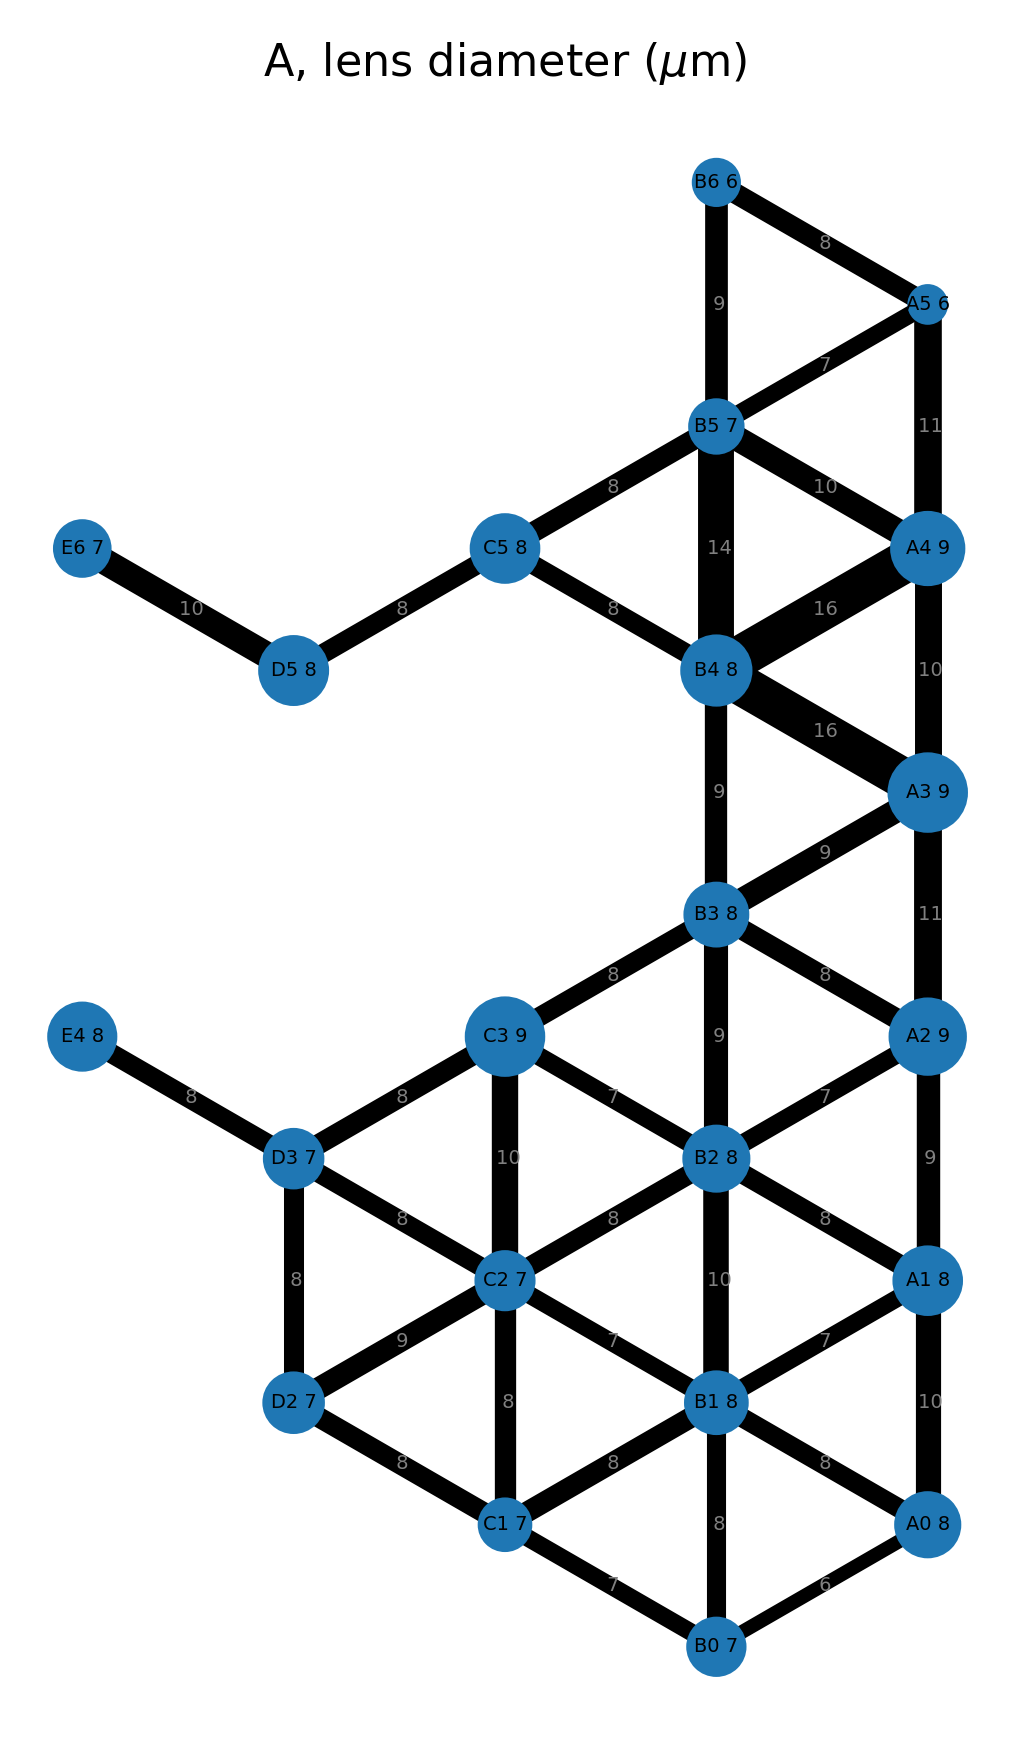

In [23]:
fig, ax = plt.subplots(1, figsize=[3, 6])
var = 'lense diameter (stack)'  # variable depicted in node size
ax.set_title(r'A, lens diameter ($\mu$m)', fontsize=8)

fx, fy = np.array([om_to_hex(om) for om in lens_centers_out.index]).T  # om coordinates in fig: specified by arangement on hex grid

node_scale = 40
sz = [(optics_df.loc[om, var] - optics_df[var].min() + 1) * node_scale for om in lens_centers_out.index]
ax.scatter(fx, fy, s=sz)

for i, om in enumerate(lens_centers_out.index): # node labels (om var)
    ax.annotate(str(om) + f"{optics_df.loc[om, var]: .0f}", (fx[i], fy[i]), 
                fontsize=3.5, horizontalalignment='center', verticalalignment='center')

# weighted line between om
for pair, d in pair_dist.iterrows():
    if d['hex_dist'] > 1.1: # non-neighboring
        continue
    else:
        x1, y1 = om_to_hex(pair[0])
        x2, y2 = om_to_hex(pair[1])
        w = (d['ret_dist'] - pair_dist['ret_dist'].min() + 5) / 2.0
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
        ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
                    fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')
ax.set_aspect('equal')
plt.axis('off')

if save_figs:
    fig.savefig(fig_path + 'ret-dist_lens-diameter' + '.svg')
    fig.savefig(fig_path + 'ret-dist_lens-diameter' + '.png')

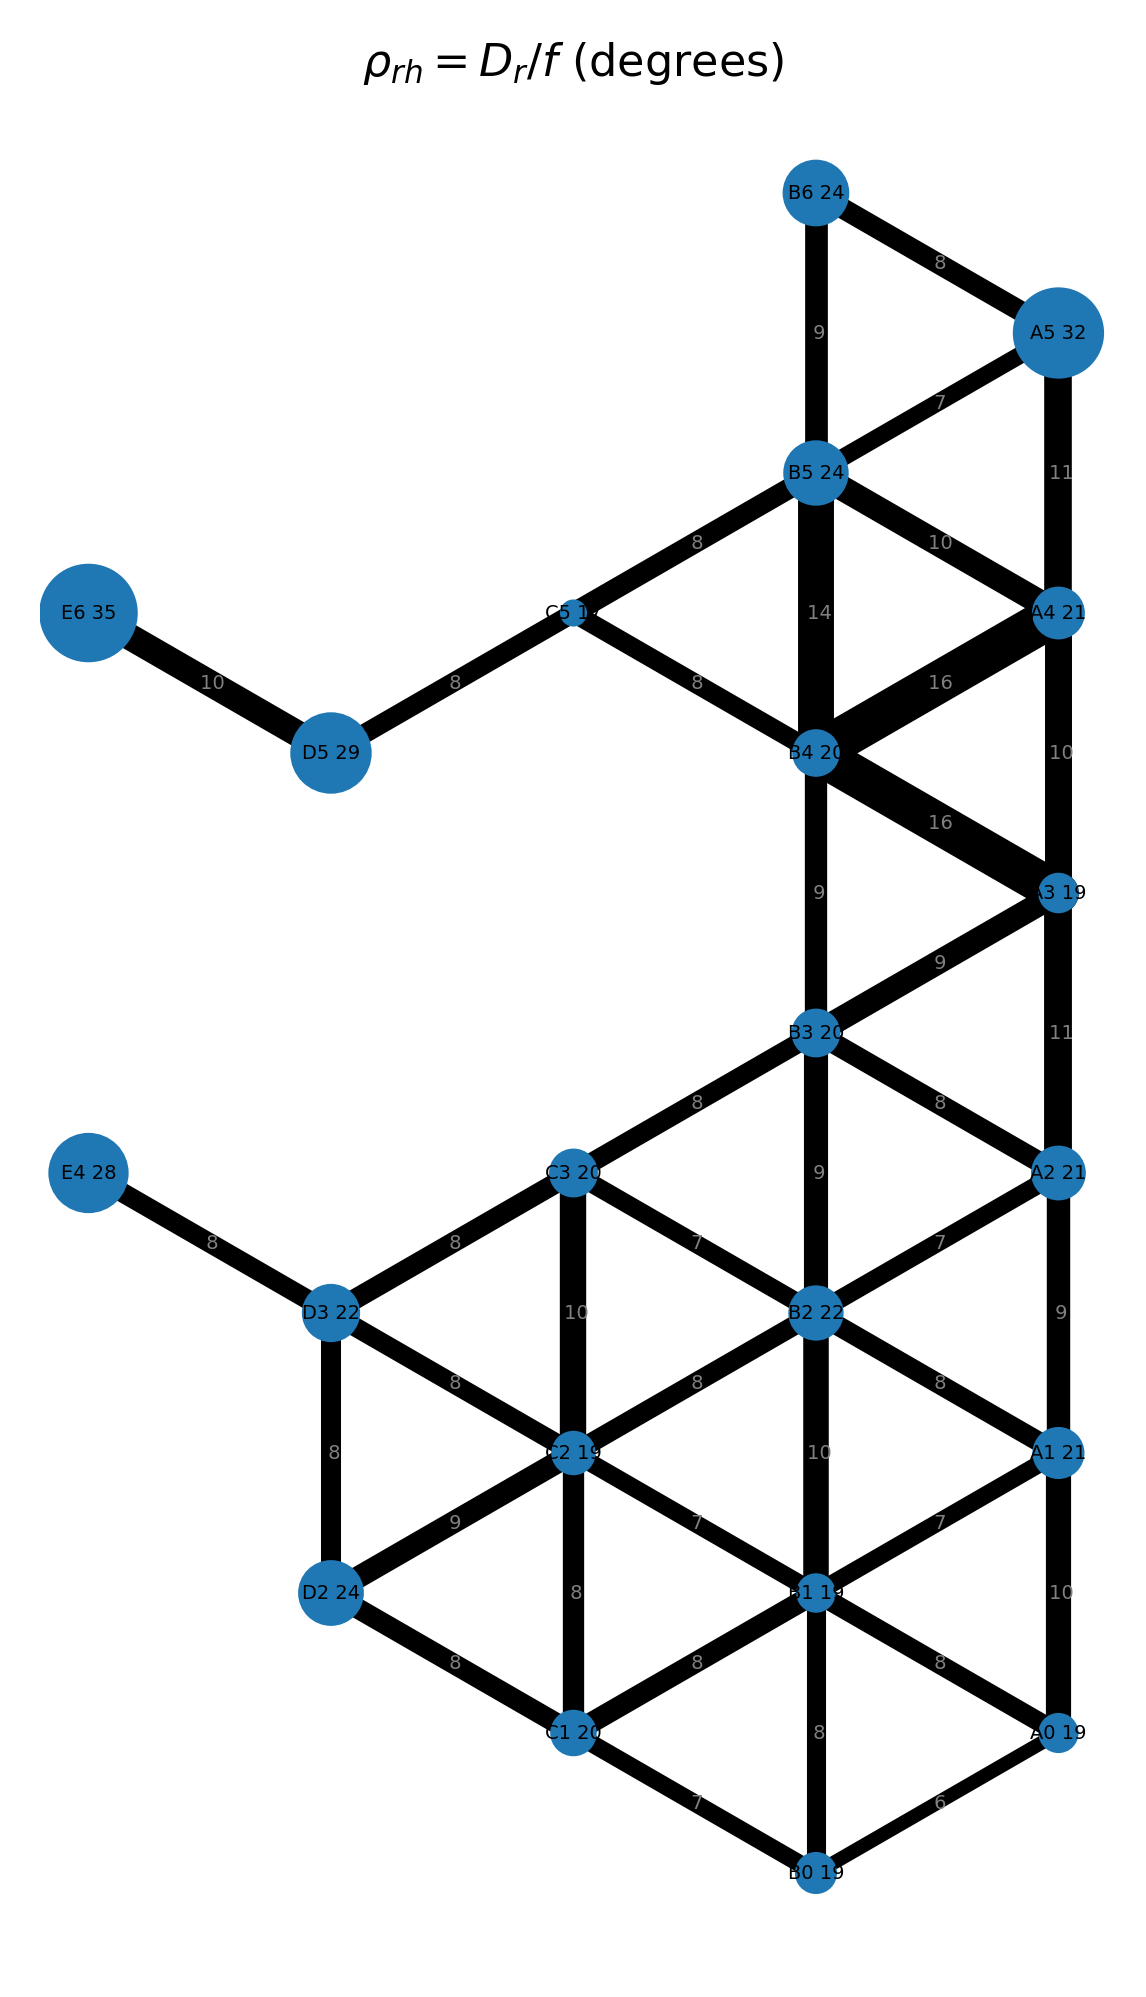

In [24]:
fig, ax = plt.subplots(1, figsize=[4, 6])
var = 'rho_rh'  # variable depicted in node size
ax.set_title(r'$\rho_{rh} = D_r/f$ (degrees)', fontsize=8)

fx, fy = np.array([om_to_hex(om) for om in lens_centers_out.index]).T  # om coordinates in fig: specified by arangement on hex grid

node_scale = 15
sz = [(optics_df.loc[om, var] - optics_df[var].min() + 1) * node_scale for om in lens_centers_out.index]
ax.scatter(fx, fy, s=sz)

for i, om in enumerate(lens_centers_out.index): # node labels (om var)
    ax.annotate(str(om) + f"{optics_df.loc[om, var]: .0f}", (fx[i], fy[i]), 
                fontsize=3.5, horizontalalignment='center', verticalalignment='center')

# weighted line between om
for pair, d in pair_dist.iterrows():
    if d['hex_dist'] > 1.1: # non-neighboring
        continue
    else:
        x1, y1 = om_to_hex(pair[0])
        x2, y2 = om_to_hex(pair[1])
        w = (d['ret_dist'] - pair_dist['ret_dist'].min() + 5) / 2.0
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
        ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
                    fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')
ax.set_aspect('equal')
plt.axis('off')

if save_figs:
    fig.savefig(fig_path + 'ret-dist_rho-rh' + '.svg')
    fig.savefig(fig_path + 'ret-dist_rho-rh' + '.png')

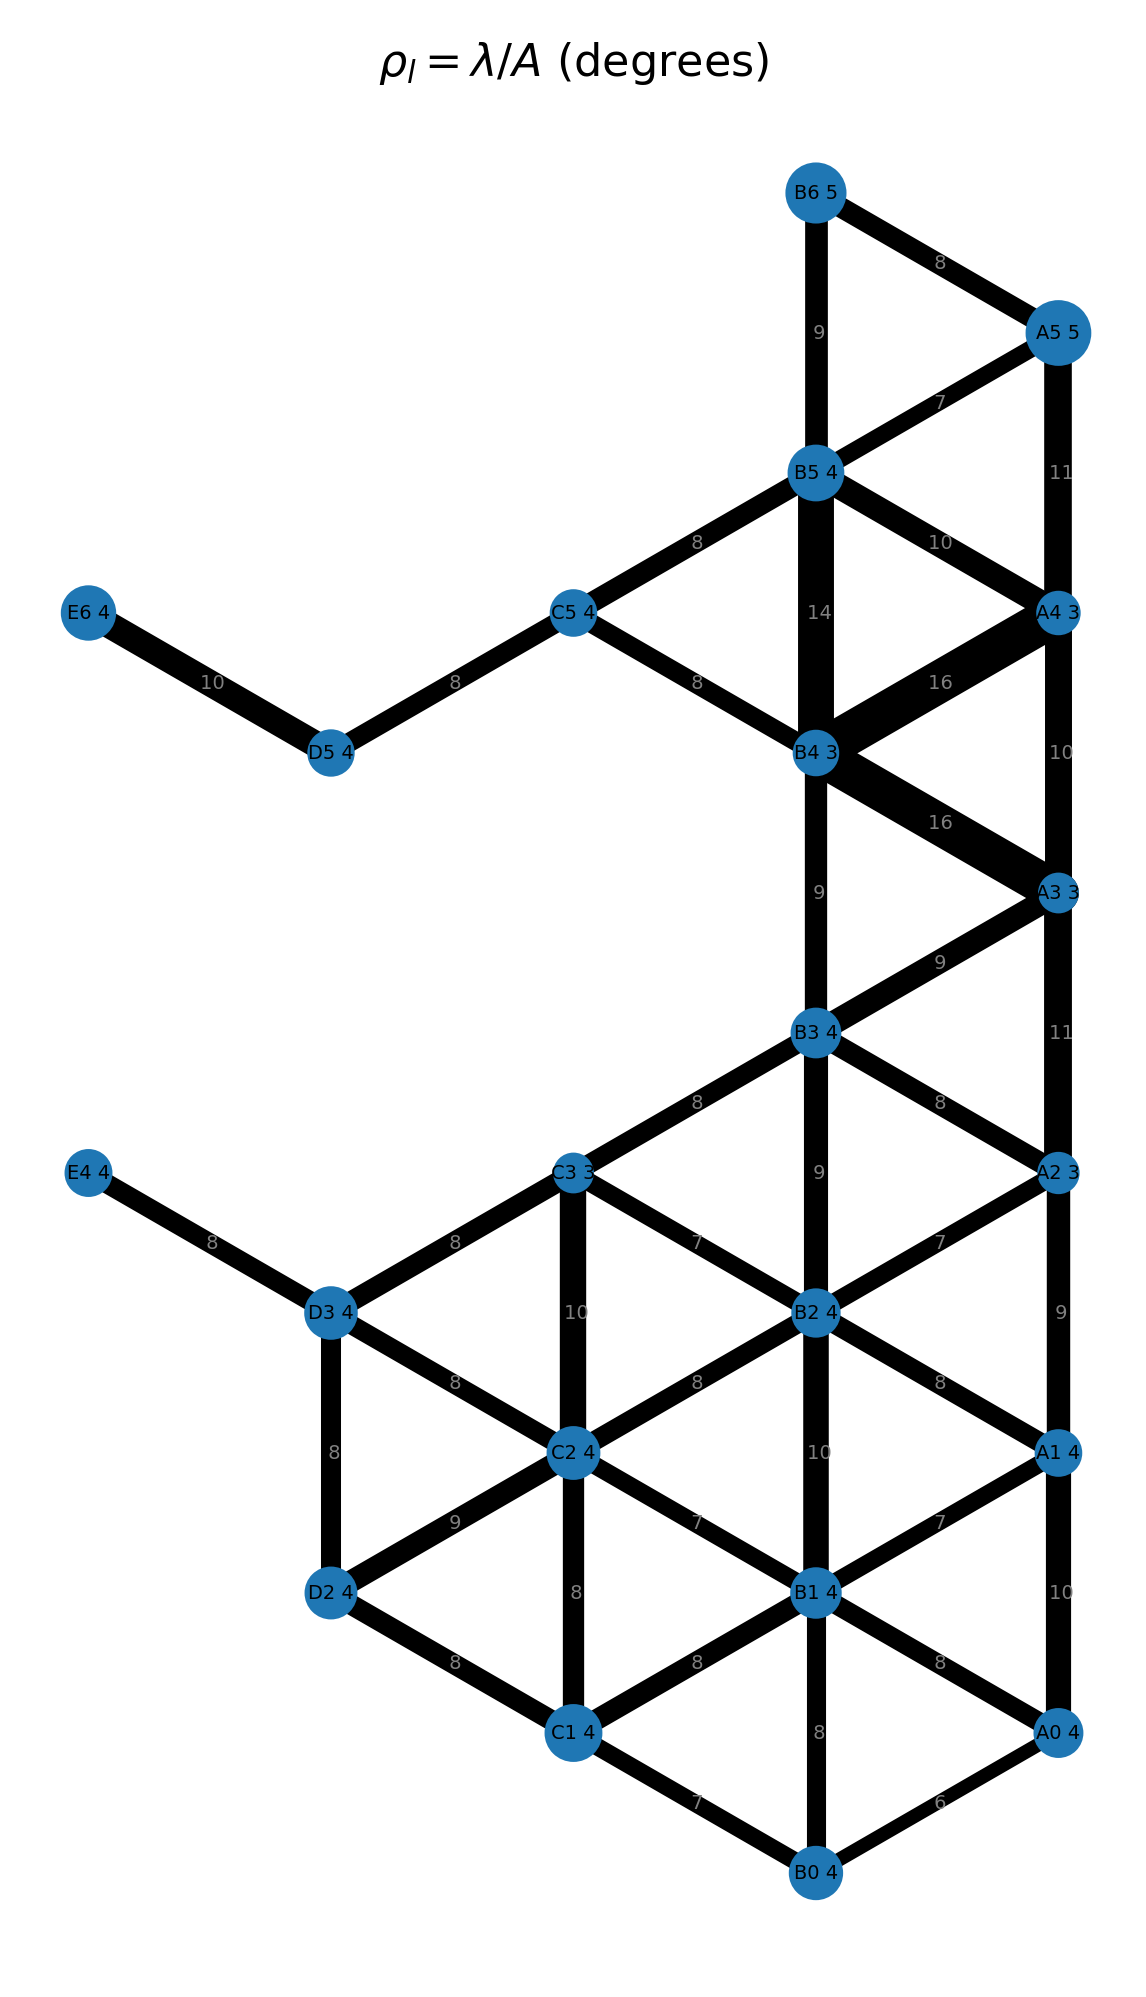

In [25]:
fig, ax = plt.subplots(1, figsize=[4, 6])
var = 'rho_l'  # variable depicted in node size
ax.set_title(r'$\rho_{l} = \lambda/A$ (degrees)', fontsize=8)

fx, fy = np.array([om_to_hex(om) for om in lens_centers_out.index]).T  # om coordinates in fig: specified by arangement on hex grid

node_scale = 40
sz = [(optics_df.loc[om, var] - optics_df[var].min() + 1) * node_scale for om in lens_centers_out.index]
ax.scatter(fx, fy, s=sz)

for i, om in enumerate(lens_centers_out.index): # node labels (om var)
    ax.annotate(str(om) + f"{optics_df.loc[om, var]: .0f}", (fx[i], fy[i]), 
                fontsize=3.5, horizontalalignment='center', verticalalignment='center')

# weighted line between om
for pair, d in pair_dist.iterrows():
    if d['hex_dist'] > 1.1: # non-neighboring
        continue
    else:
        x1, y1 = om_to_hex(pair[0])
        x2, y2 = om_to_hex(pair[1])
        w = (d['ret_dist'] - pair_dist['ret_dist'].min() + 5) / 2.0
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
        ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
                    fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')
ax.set_aspect('equal')
plt.axis('off')

if save_figs:
    fig.savefig(fig_path + 'ret-dist_rho-l' + '.svg')
    fig.savefig(fig_path + 'ret-dist_rho-l' + '.png')

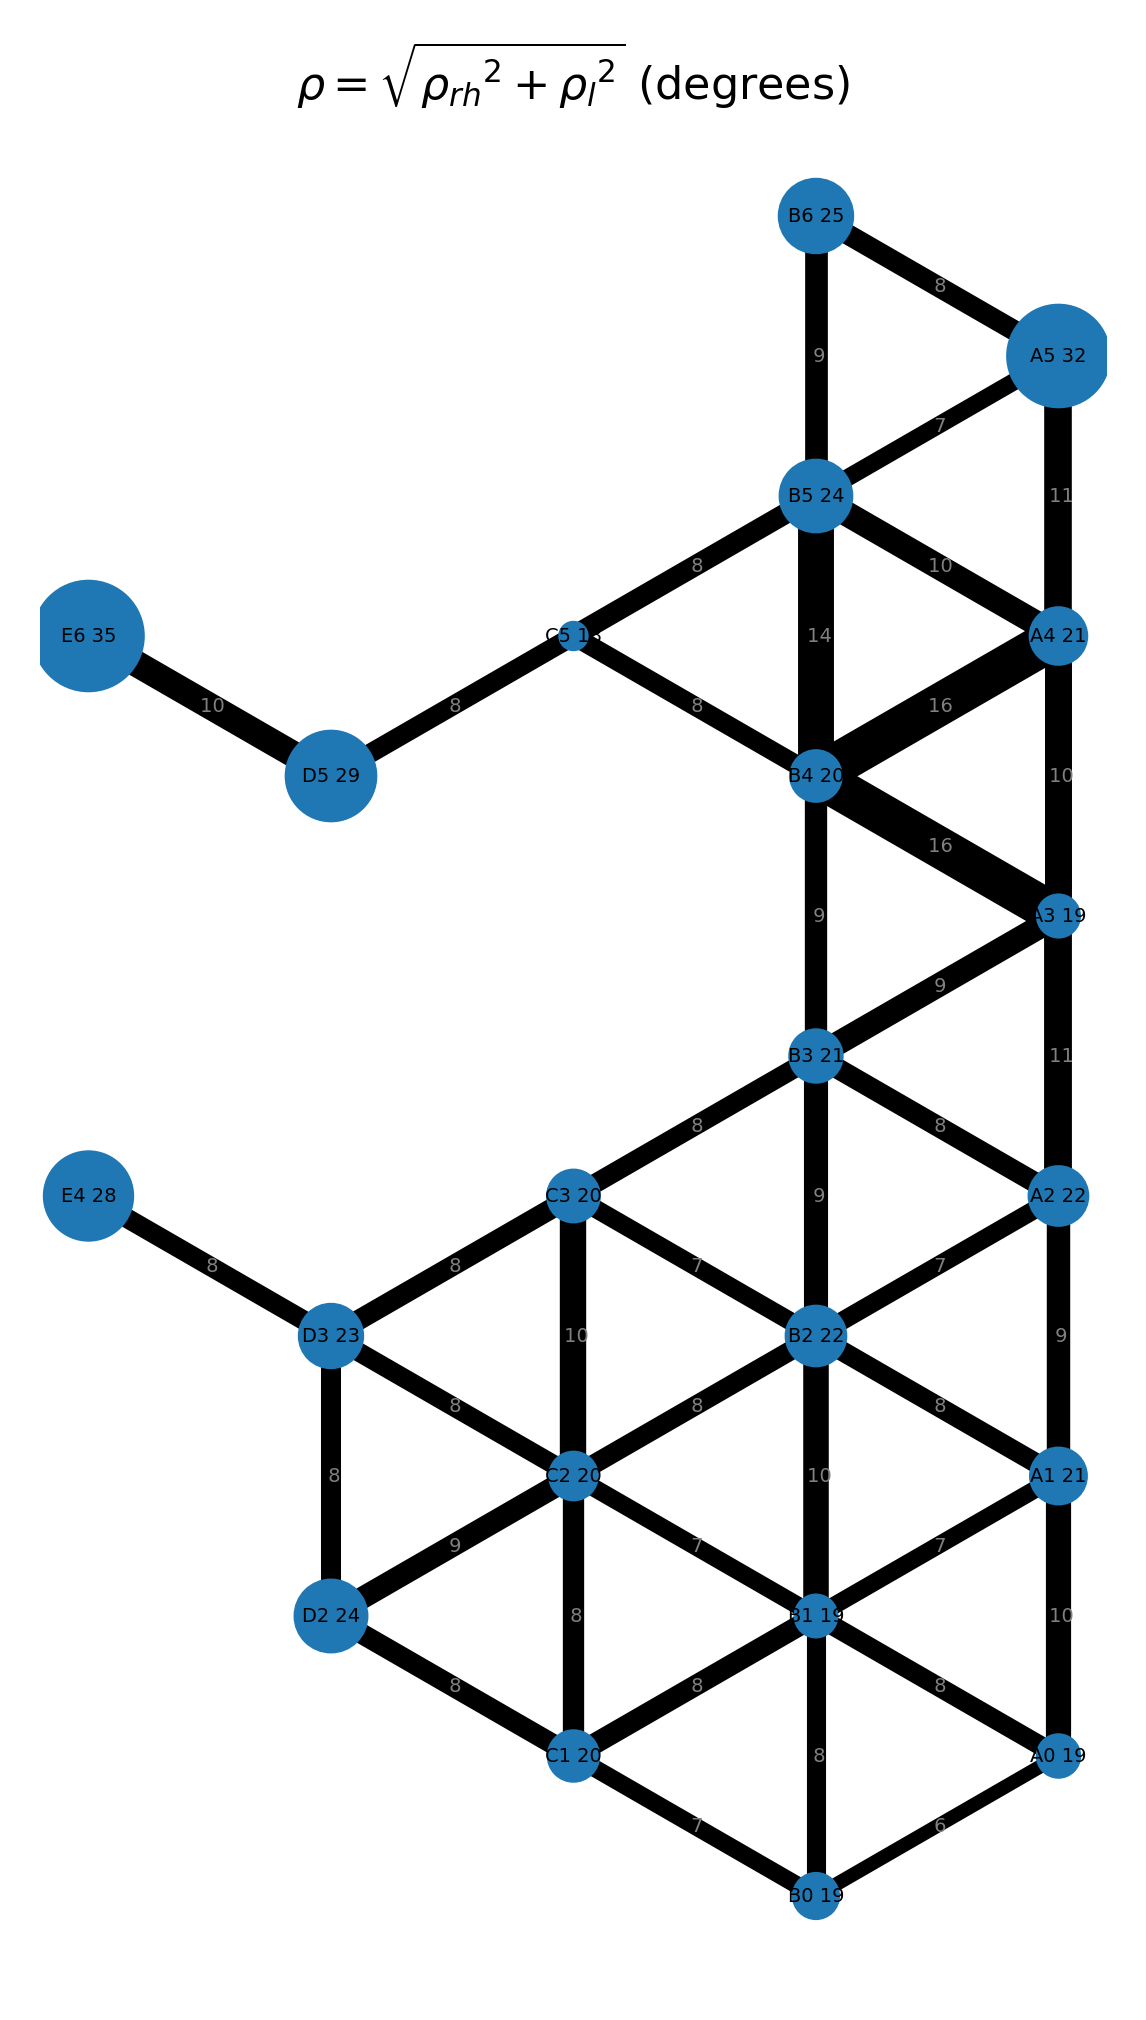

In [26]:
fig, ax = plt.subplots(1, figsize=[4, 6])
var = 'rho'  # variable depicted in node size
ax.set_title(r'$\rho = \sqrt{{\rho_{rh}}^2 + {\rho_l}^2}$ (degrees)', fontsize=8)

fx, fy = np.array([om_to_hex(om) for om in lens_centers_out.index]).T  # om coordinates in fig: specified by arangement on hex grid

node_scale = 20
sz = [(optics_df.loc[om, var] - optics_df[var].min() + 1) * node_scale for om in lens_centers_out.index]
ax.scatter(fx, fy, s=sz)

for i, om in enumerate(lens_centers_out.index): # node labels (om var)
    ax.annotate(str(om) + f"{optics_df.loc[om, var]: .0f}", (fx[i], fy[i]), 
                fontsize=3.5, horizontalalignment='center', verticalalignment='center')

# weighted line between om
for pair, d in pair_dist.iterrows():
    if d['hex_dist'] > 1.1: # non-neighboring
        continue
    else:
        x1, y1 = om_to_hex(pair[0])
        x2, y2 = om_to_hex(pair[1])
        w = (d['ret_dist'] - pair_dist['ret_dist'].min() + 5) / 2.0
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
        ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
                    fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')
ax.set_aspect('equal')
plt.axis('off')

if save_figs:
    fig.savefig(fig_path + 'ret-dist_rho-overall' + '.svg')
    fig.savefig(fig_path + 'ret-dist_rho-overall' + '.png')

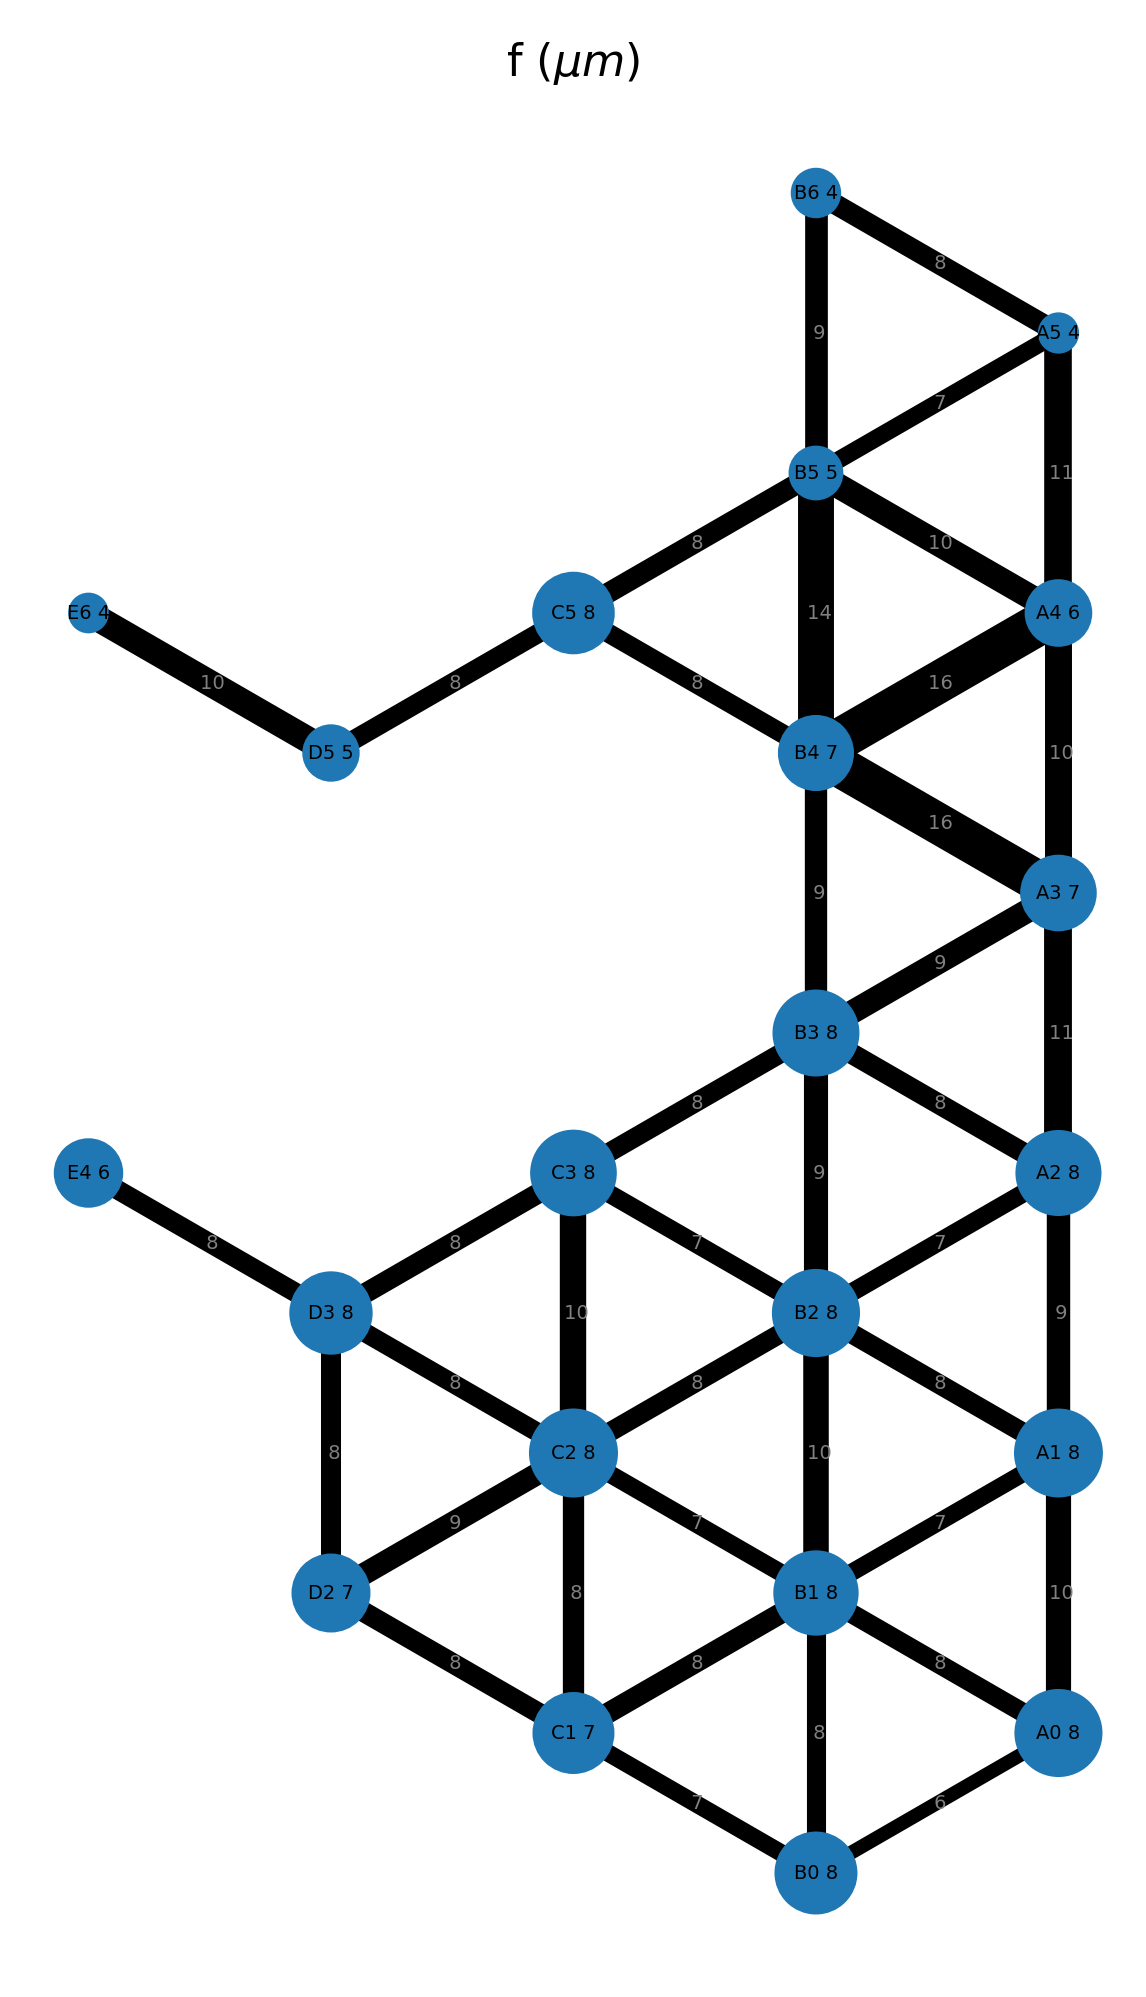

In [27]:
fig, ax = plt.subplots(1, figsize=[4, 6])
var = 'f'  # variable depicted in node size
ax.set_title(r'f $(\mu{m})$', fontsize=8)

fx, fy = np.array([om_to_hex(om) for om in lens_centers_out.index]).T  # om coordinates in fig: specified by arangement on hex grid

node_scale = 40
sz = [(optics_df.loc[om, var] - optics_df[var].min() + 1) * node_scale for om in lens_centers_out.index]
ax.scatter(fx, fy, s=sz)

for i, om in enumerate(lens_centers_out.index): # node labels (om var)
    ax.annotate(str(om) + f"{optics_df.loc[om, var]: .0f}", (fx[i], fy[i]), 
                fontsize=3.5, horizontalalignment='center', verticalalignment='center')

# weighted line between om
for pair, d in pair_dist.iterrows():
    if d['hex_dist'] > 1.1: # non-neighboring
        continue
    else:
        x1, y1 = om_to_hex(pair[0])
        x2, y2 = om_to_hex(pair[1])
        w = (d['ret_dist'] - pair_dist['ret_dist'].min() + 5) / 2.0
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
        ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
                    fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')
ax.set_aspect('equal')
plt.axis('off')

if save_figs:
    fig.savefig(fig_path + 'ret-dist_f' + '.svg')
    fig.savefig(fig_path + 'ret-dist_f' + '.png')

(0.03626933041053579,
 0.41732050807568877,
 -0.08000000000000002,
 0.5800000000000001)

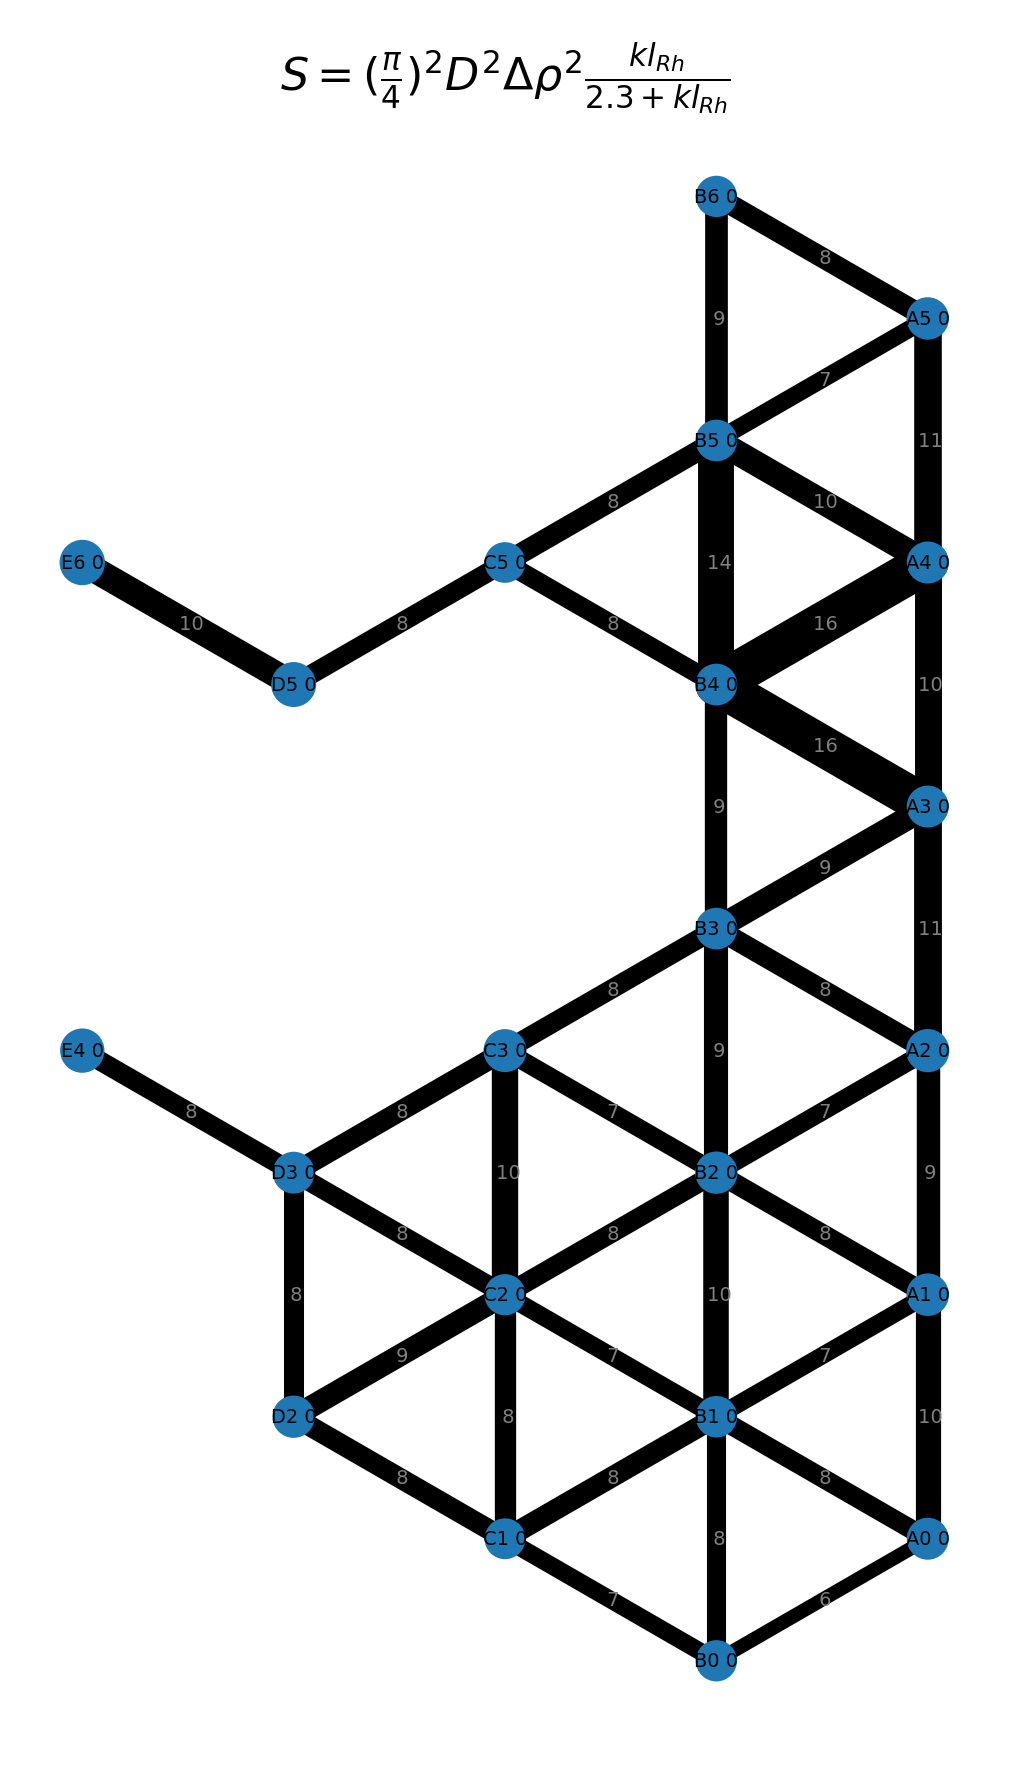

In [28]:
fig, ax = plt.subplots(1, figsize=[3, 6])
var = 'S'  # variable depicted in node size
ax.set_title(r'$S = (\frac{\pi}{4})^2 D^2 {\Delta\rho}^2 \frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$', fontsize=8)

fx, fy = np.array([om_to_hex(om) for om in lens_centers_out.index]).T  # om coordinates in fig: specified by arangement on hex grid

node_scale = 40
sz = [(optics_df.loc[om, var] - optics_df[var].min() + 1) * node_scale for om in lens_centers_out.index]
ax.scatter(fx, fy, s=sz)

for i, om in enumerate(lens_centers_out.index): # node labels (om var)
    ax.annotate(str(om) + f"{optics_df.loc[om, var]: .0f}", (fx[i], fy[i]), 
                fontsize=3.5, horizontalalignment='center', verticalalignment='center')

# weighted line between om
for pair, d in pair_dist.iterrows():
    if d['hex_dist'] > 1.1: # non-neighboring
        continue
    else:
        x1, y1 = om_to_hex(pair[0])
        x2, y2 = om_to_hex(pair[1])
        w = (d['ret_dist'] - pair_dist['ret_dist'].min() + 5) / 2.0
        ax.plot([x1, x2], [y1, y2], linewidth=w, color='k', zorder=0, solid_capstyle='round')
        ax.annotate(f"{d['ret_dist']: .0f}", ((x1 + x2)/2.0, (y1 + y2)/2.0), 
                    fontsize=3.5, color='grey', horizontalalignment='center', verticalalignment='center')
ax.set_aspect('equal')
plt.axis('off')

In [29]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
ndra_om = [str(o) for o in optics_df.index if o not in dra_om]
optics_df['region'] = ['dra' if (om in dra_om) else 'ndra' for om in optics_df.index]
display(optics_df.groupby('region').describe().T)

# regional_summary = pd.DataFrame([optics_df.mean(), optics_df.std(ddof=0), 
#                                  optics_df.loc[ndra_om].mean(), optics_df.loc[ndra_om].std(ddof=0), 
#                                  optics_df.loc[dra_om].mean(), optics_df.loc[dra_om].std(ddof=0)], 
#                                 index=['All_mean', 'All_SD', 'NDRA_mean', 'NDRA_SD', 'DRA_mean', 'DRA_SD'])

region                      dra       ndra
lense thickness count  8.000000  21.000000
                mean   2.327331   3.274723
                std    0.450714   0.388362
                min    1.886340   2.652850
                25%    1.988127   2.964610
...                         ...        ...
S               min    0.138387   0.148186
                25%    0.167427   0.194323
                50%    0.184531   0.214302
                75%    0.203934   0.267771
                max    0.239871   0.422374

[136 rows x 2 columns]

- Diffraction by the facet lens depends on light wavelength, lens diameter, and its focal distance
- Male blowfly, Calliphora (Stavenga 1990): D=20-40 $\mu{m}$; $f/D$ remains relatively constant despite range of D, giving $F = 2.0{\pm}0.2$ (based on optical measurements); 

## Distance between lens and rhabdom is linearly related to the focal length of the diopteric apparatus 

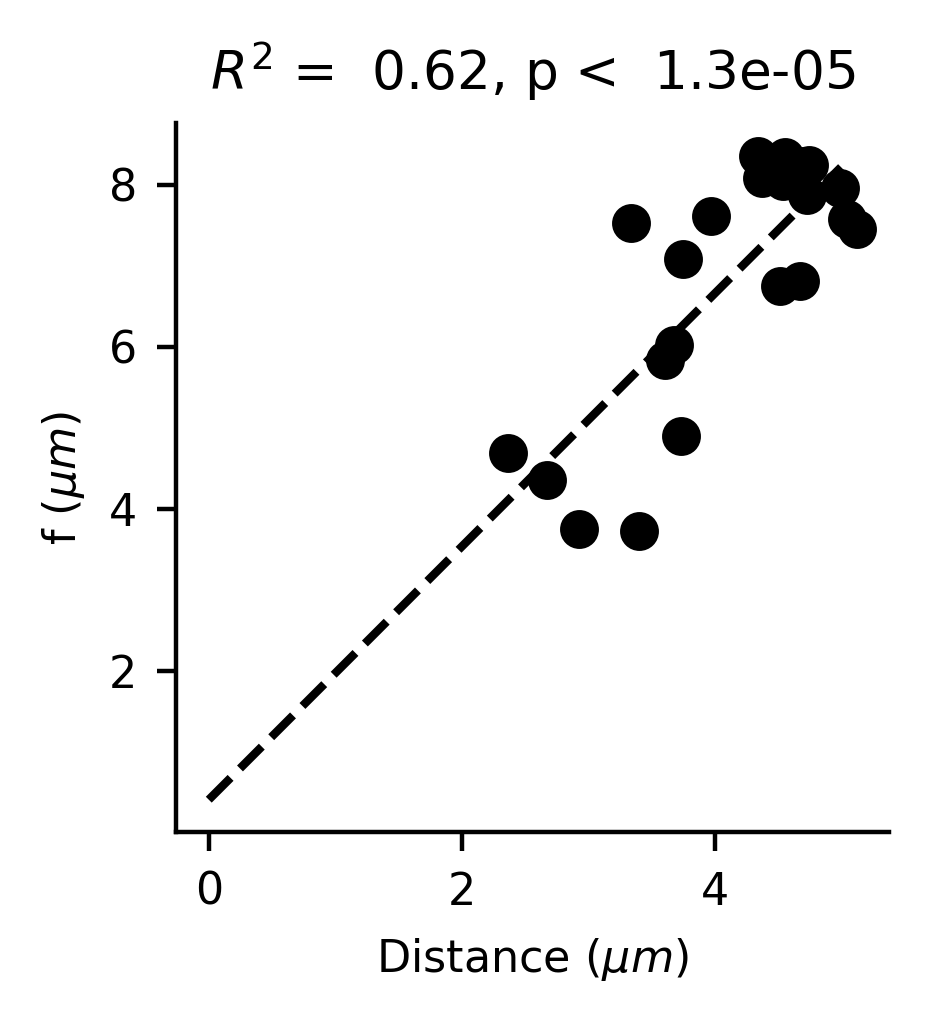

const                         0.404242
cone length (from the tip)    1.562843
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      f   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     33.01
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           1.27e-05
Time:                        15:59:45   Log-Likelihood:                -29.827
No. Observations:                  22   AIC:                             63.65
Df Residuals:                      20   BIC:                             65.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.4042      1.130      0.358      0.724      -1.952       2.761
cone length (from the tip)     1.5628      0.272      5.745      0.000       0.995       2.130
==============================================================================
Omnibus:                        0.224   Durbin-Watson:                   1.454
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.405
Skew:                          -0.163   Prob(JB):                        0.817
Kurtosis:                       2.420   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
Y = optics_df['f'].dropna()
_x = optics_df.loc[Y.index, 'cone length (from the tip)']
X = sm.add_constant(_x)


model = sm.OLS(Y, X)
results = model.fit()
params = results.params
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Distance ($\mu{m}$)')
ax.set_ylabel("f ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['cone length (from the tip)'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-dist_scatter' + '.png')

# SHOW OLS RESULTS
display(params)
display(results.summary())

# Focal length is also linearly related to the distal diameter of the rhabdom
- $D_{Rh} / f$ approximates the ommatidium's acceptance angle based on the geometry of the lens and rhabdom surface 

const             -0.992589
D rhabdom dist.    3.028286
dtype: float64

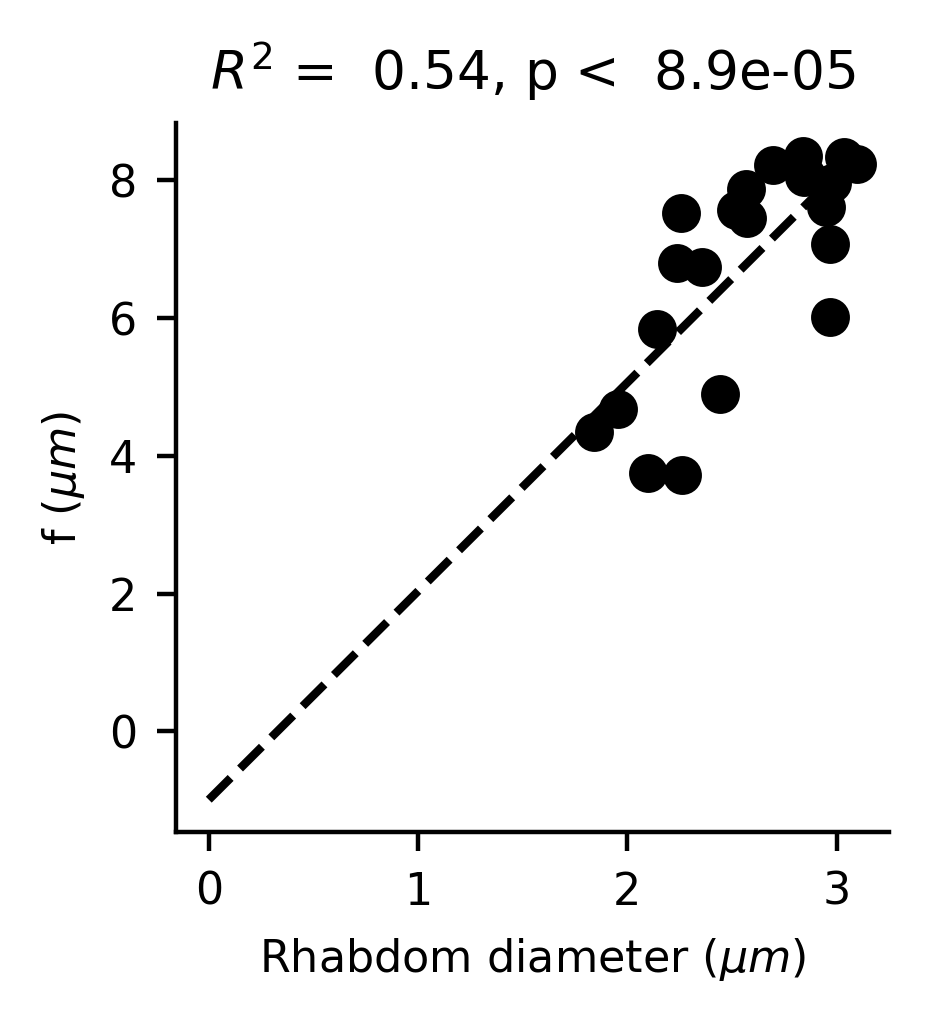

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      f   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     23.89
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           8.89e-05
Time:                        15:59:46   Log-Likelihood:                -31.903
No. Observations:                  22   AIC:                             67.81
Df Residuals:                      20   BIC:                             69.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9926      1.607     -0.618      0.544      -4.345       2.360
D rhabdom dist.     3.0283      0.620      4.888      0.000       1.736       4.321
==============================================================================
Omnibus:                        2.130   Durbin-Watson:                   1.141
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                1.782
Skew:                          -0.651   Prob(JB):                        0.410
Kurtosis:                       2.499   Cond. No.                         20.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
Y = optics_df['f'].dropna()
_x = optics_df.loc[Y.index, 'D rhabdom dist.'] 
X = sm.add_constant(_x)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom diameter ($\mu{m}$)')
ax.set_ylabel("f ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig(fig_path + 'focal_rhabdom-diam_scatter' + '.svg')
    fig.savefig(fig_path + 'focal_rhabdom-diam_scatter' + '.png')

# SHOW OLS RESULTS
display(results.summary())

[0.26897186 0.16599309 0.20431599 0.13127042 0.14117409 0.13290111
 0.12425909 0.11961998 0.13426268 0.22983968 0.21357141 0.14821085
 0.12369519 0.12129348 0.12700612 0.13206886 0.26664196 0.17126228
 0.1469008  0.12555219 0.11985735 0.12148999]
[[ 1.         35.10099528]
 [ 1.         28.46946606]
 [ 1.         28.83053358]
 [ 1.         22.5338054 ]
 [ 1.         24.33046922]
 [ 1.         17.54295997]
 [ 1.         20.47459166]
 [ 1.         19.84847695]
 [ 1.         20.26406891]
 [ 1.         24.68411876]
 [ 1.         24.29607782]
 [ 1.         20.29883074]
 [ 1.         20.56816736]
 [ 1.         21.83136177]
 [ 1.         19.05430289]
 [ 1.         19.48655976]
 [ 1.         32.44557666]
 [ 1.         21.271979  ]
 [ 1.         19.08021549]
 [ 1.         21.65687307]
 [ 1.         21.15218263]
 [ 1.         19.12679654]]


array([-0.04540498,  0.00889635])

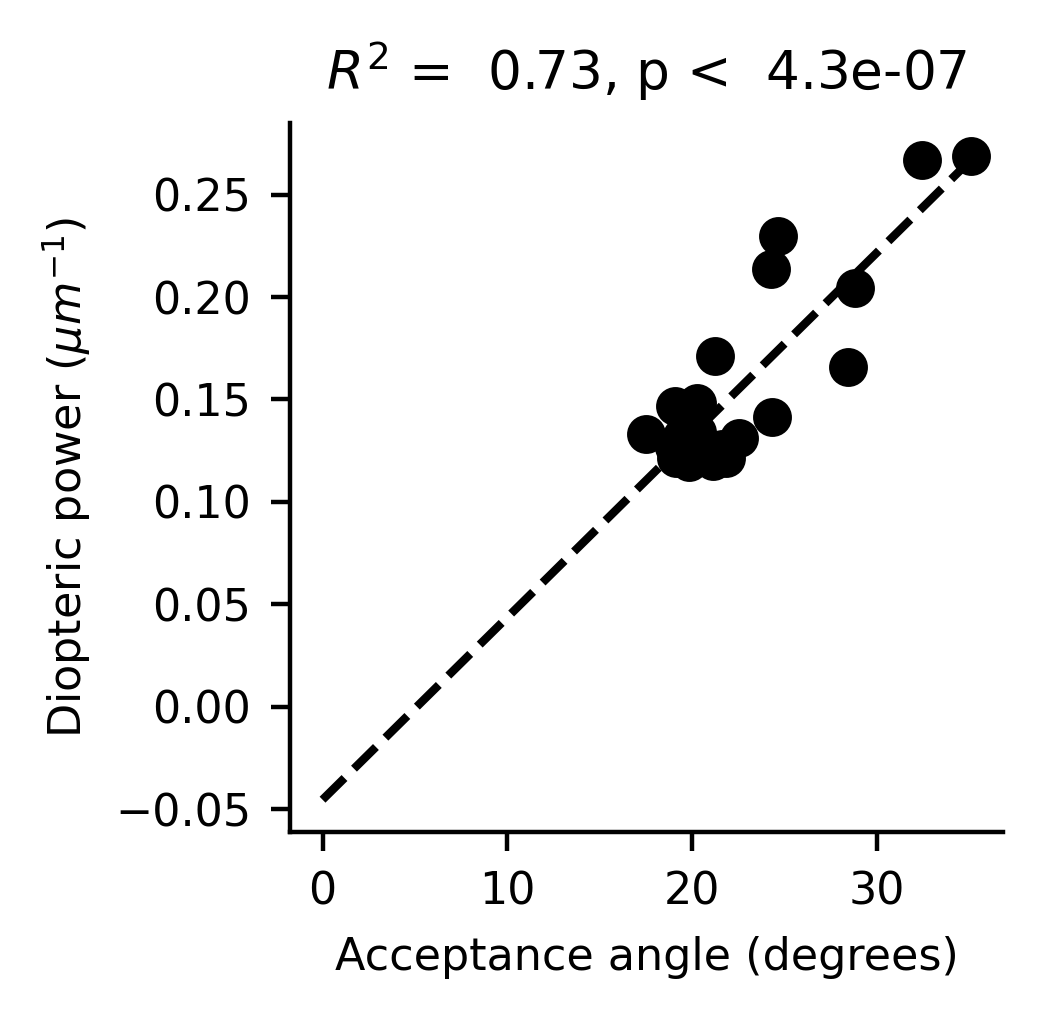

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     53.84
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           4.31e-07
Time:                        15:59:46   Log-Likelihood:                 50.608
No. Observations:                  22   AIC:                            -97.22
Df Residuals:                      20   BIC:                            -95.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0454      0.028     -1.610      0.123      -0.104       0.013
x1             0.0089      0.001      7.338      0.000       0.006       0.011
==============================================================================
Omnibus:                        1.121   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.948
Skew:                           0.465   Prob(JB):                        0.622
Kurtosis:                       2.589   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'f'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

print(np.asarray(Y))
print(X)

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_ylabel('Diopteric power ($\mu{m}^{-1}$)')
ax.set_xlabel("Acceptance angle (degrees)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

array([-0.04540498,  0.00889635])

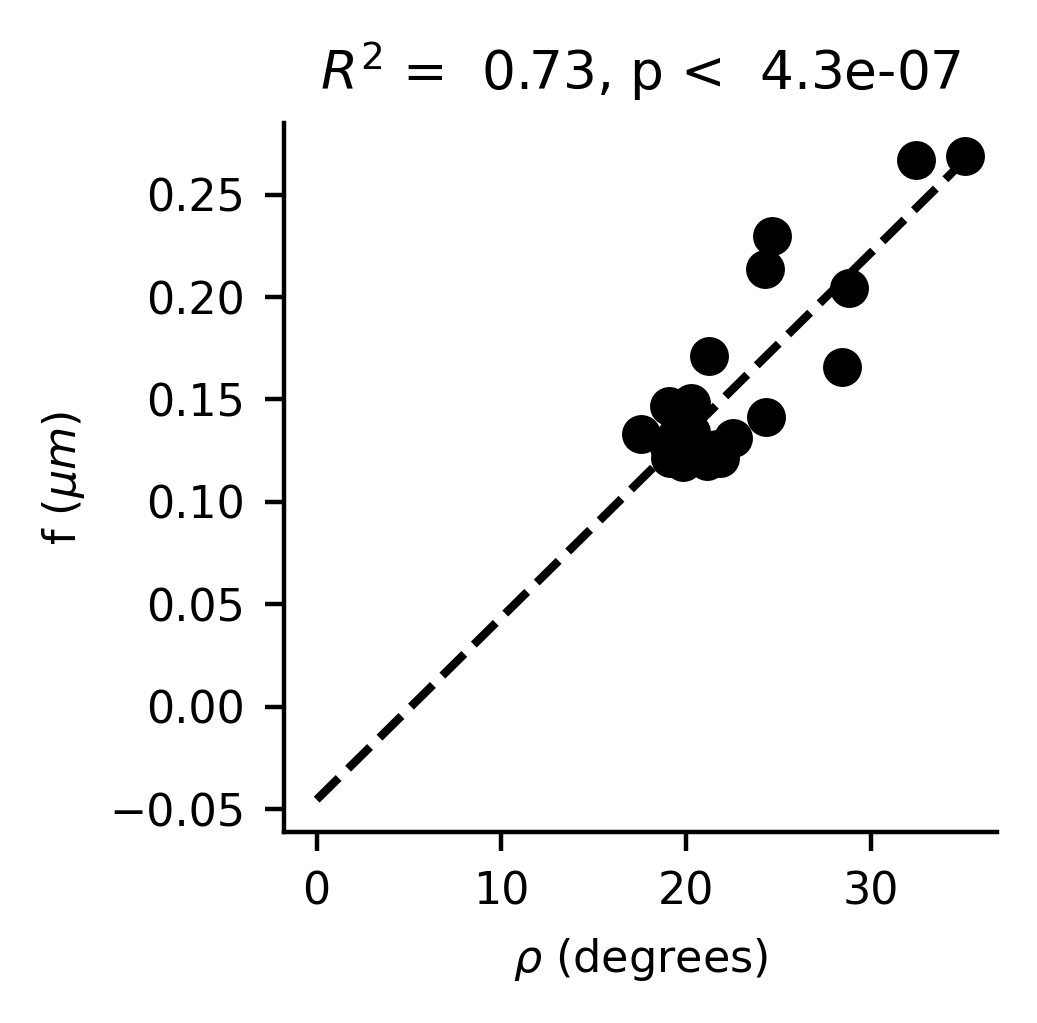

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     53.84
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           4.31e-07
Time:                        15:59:46   Log-Likelihood:                 50.608
No. Observations:                  22   AIC:                            -97.22
Df Residuals:                      20   BIC:                            -95.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0454      0.028     -1.610      0.123      -0.104       0.013
x1             0.0089      0.001      7.338      0.000       0.006       0.011
==============================================================================
Omnibus:                        1.121   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.948
Skew:                           0.465   Prob(JB):                        0.622
Kurtosis:                       2.589   Cond. No.                         121.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'f'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel(r'$\rho$ (degrees)')
ax.set_ylabel("f ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

array([0.09365537987814064, 0.0016822683359119632], dtype=object)

TypeError: No loop matching the specified signature and casting was found for ufunc add

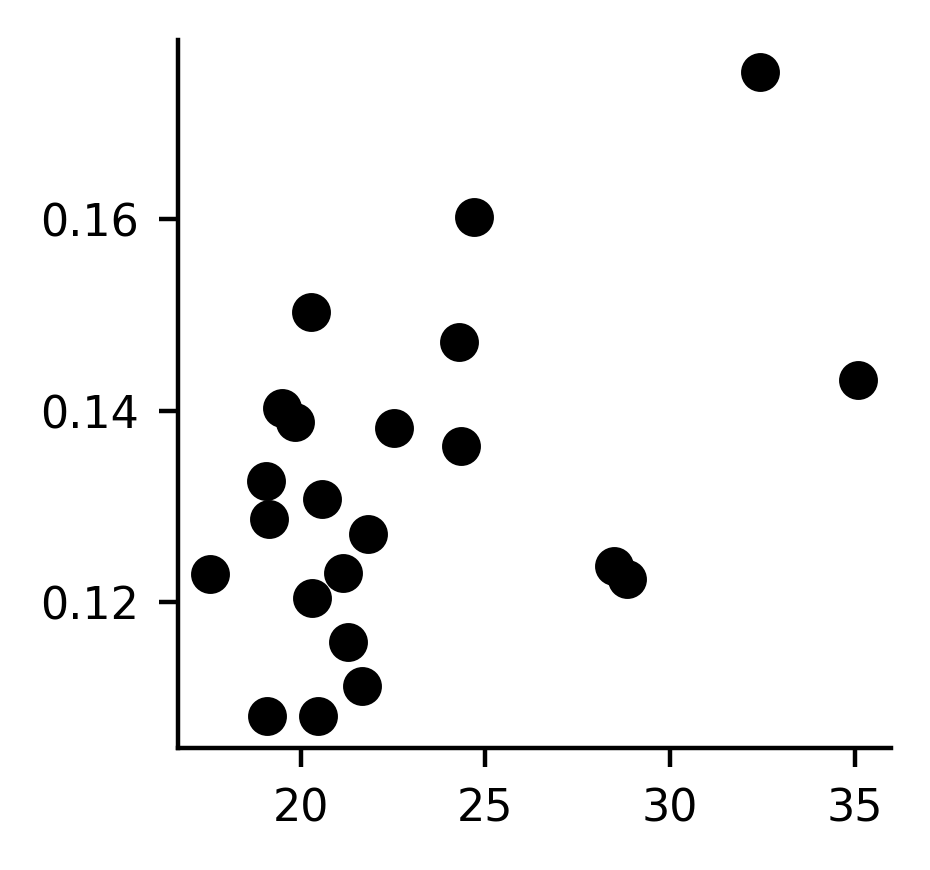

In [34]:
Y = 1.0/np.asarray(optics_df.loc[lens_centers_out.index, 'lense diameter (stack)'])
_x = optics_df.loc[lens_centers_out.index, 'rho'] 
X = np.asarray(sm.add_constant(_x))

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

# c = []
# for om in optics_df.index:
#     if om in dra_om:
#         c.append('darkviolet')
#     else:
#         c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c='k', marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel(r'$\rho$ (degrees)')
ax.set_ylabel("Diopteric power ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params[0] + params[1] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

/Users/nchua/src/cx-analysis/cx_analysis/vis/fig_tools.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clist = np.array([min_colour, max_colour])


IndexError: list index out of range

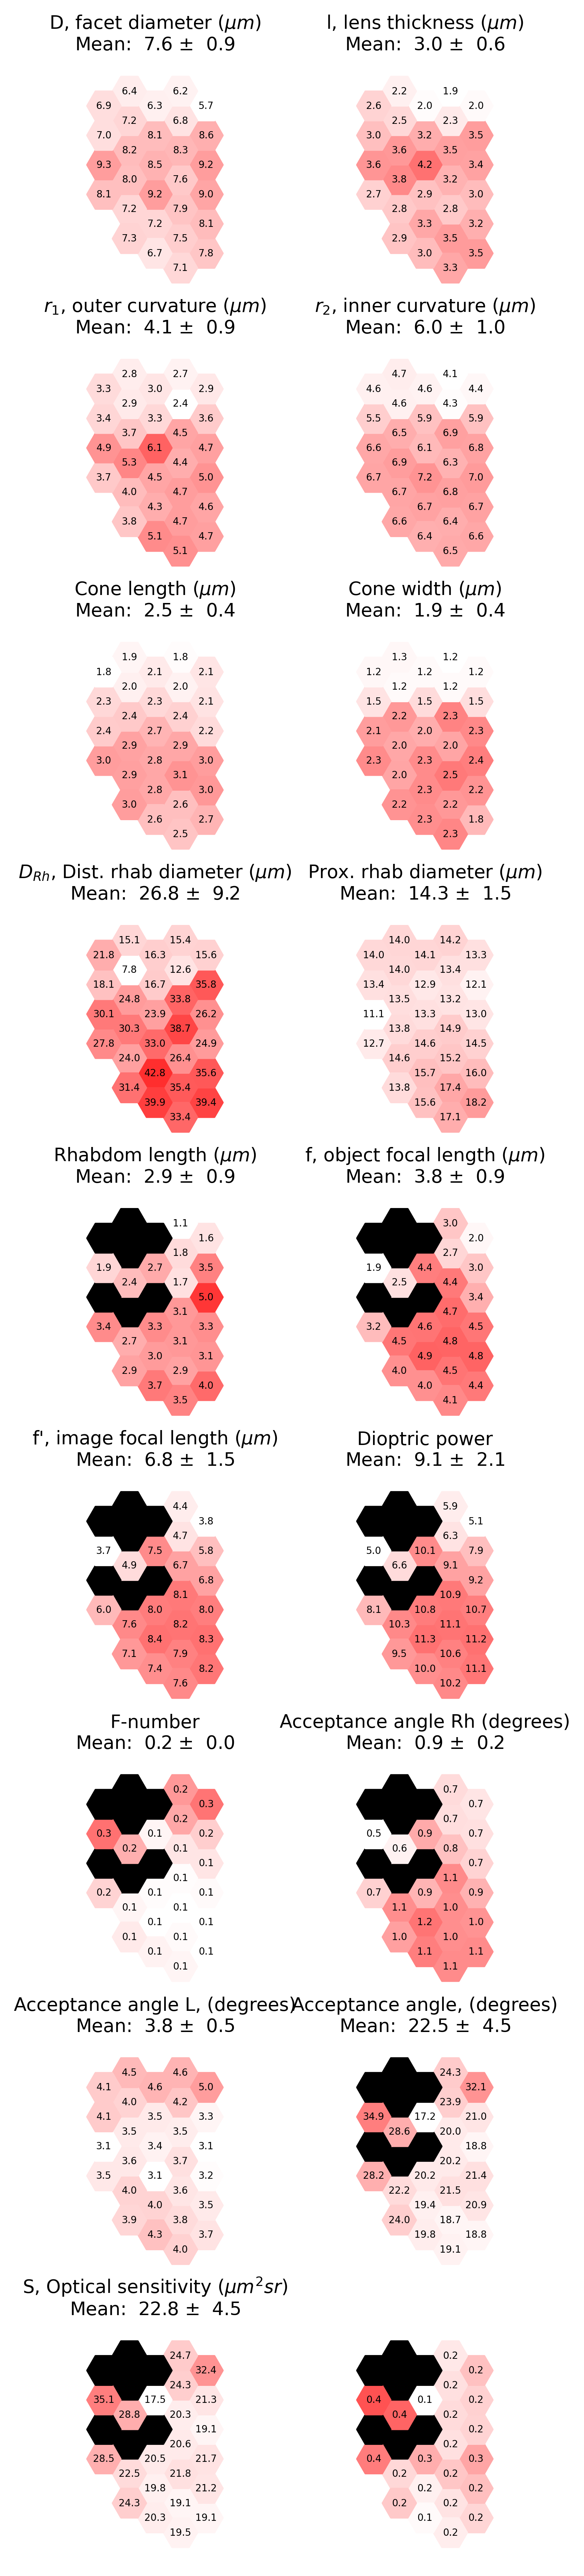

In [35]:
fig, ax = plt.subplots(9, 2, figsize=(4.6, 9.0*2.6))
axes = ax.flatten()
lincm = linear_cmap(n_vals=100, max_colour='r')

param_labels = ['D, facet diameter ($\mu{m}$)', 'l, lens thickness ($\mu{m}$)', '$r_1$, outer curvature ($\mu{m}$)',
               '$r_2$, inner curvature ($\mu{m}$)', 'Cone length ($\mu{m}$)', 'Cone width ($\mu{m}$)', '$D_{Rh}$, Dist. rhab diameter ($\mu{m}$)', 
               'Prox. rhab diameter ($\mu{m}$)', 'Rhabdom length ($\mu{m}$)', 'f, object focal length ($\mu{m}$)', "f', image focal length ($\mu{m}$)",
               'Dioptric power', 'F-number', 'Acceptance angle Rh (degrees)', 'Acceptance angle L, (degrees)', 'Acceptance angle, (degrees)', 
               'S, Optical sensitivity ($\mu{m}^2 sr$)']


i = 0
for param, vals in optics_df.iteritems():
    max_val = vals.max()
    min_val = vals.min()
    
    node_data = {om: {'label': np.round(v, decimals=1),
                      'colour': lincm((v-min_val)/max_val)} for om, v in vals.items()}
    hexplot(node_data, ax=axes[i])
    axes[i].set_title(f"{param_labels[i]}\n" + 
                      f"Mean: {vals.mean(): .1f} $\pm$ {vals.std(ddof=0): .1f}")
    i += 1
axes[-1].set_visible(False)
plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.png')